# 1. 데이터 수집하기
+ 요기요와 구글맵에 존재하는 '성균관대(서울)' 근처의 치킨집 20개의 리뷰들을 수집한다.

## 1-1. 요기요 리뷰 수집하기


### 1) 가게별 고유 번호 수집

In [ ]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-brower/chromedriver/usr/bin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 24.5 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,619 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get

In [ ]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

!pip install selenium
!pip install webdriver_manager

from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
from selenium.webdriver.support.ui import Select
import requests
from urllib.parse import quote
import time
import pandas as pd
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--no-sandbox")
driver = webdriver.Chrome(options=options)

In [ ]:
store_info = pd.DataFrame()

In [ ]:
#url로 이동한 후 가게들의 고유 번호 찾기
def store_id(driver):
  global store_info

  #치킨 카테고리 클릭
  XPATH = '//*[@id="category"]/ul/li[5]/span'
  category_element = WebDriverWait(driver, 10).until(
              EC.presence_of_element_located((By.XPATH, XPATH))
          )
  driver.execute_script("arguments[0].click();", category_element)

  #리뷰 많은 순서로 정렬하기
  dropdown = driver.find_element(By.XPATH, '//*[@id="content"]/div/div[1]/div[2]/div/select')
  select = Select(dropdown)
  time.sleep(1)
  select.select_by_value("review_count")

  #치킨 카테고리에 속한 가게 20개의 고유 번호 찾기
  for i in range(20):
    stores = WebDriverWait(driver, 10).until(
              EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".restaurant-name.ng-binding")))[:20]
    stores[i].click()
    time.sleep(2)

    store_url = driver.current_url.rstrip('/').split('/')[-1] #가게 고유 번호
    store_name = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".restaurant-name.ng-binding"))).text
    review_count = WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CSS_SELECTOR, 'li[ng-class*="review"] .ng-binding'))).text

    data = pd.DataFrame({
                  'id': [store_url], # 가게 ID
                  'name' : [store_name],
                  'review_count' : [review_count] #리뷰 수
              })
    store_info = pd.concat([store_info, data])
    driver.back()
    time.sleep(2)

In [ ]:
def move_to_url(driver, search_key):
  url = "https://www.yogiyo.co.kr/mobile/#/"
  driver.get(url)
  time.sleep(2)

  search_box = driver.find_element(By.XPATH, '//*[@id="search"]/div/form/input')
  search_button = driver.find_element(By.XPATH, '//*[@id="button_search_address"]/button[2]')

  # 검색어 입력 및 버튼 클릭
  search_box.send_keys(search_key)
  time.sleep(1)
  search_button.click()
  time.sleep(2)
  try:
    elements = WebDriverWait(driver, 10).until(
        EC.visibility_of_all_elements_located((By.CSS_SELECTOR, ".ng-binding.ng-scope"))
    )
  except:
    elements = None
  if elements:
    elements[1].click()
  return driver

In [ ]:
search_keys = ['서울 송파구 신천동 29-5 송파구청','마포구청','강남구청','관악구청','강서구청','성북구청',
               '영등포구청','은평구청','양천구청','구로구청','서울특별시 종로구 예지동 293-1 종로광장시장','서울특별시 중구 남창동 4-2 남대문시장','명동','서울특별시 종로구 연건동 128-8 홍익대학교대학로캠퍼스',
               '혜화동로터리','충무아트센터']

for key in search_keys:
  tell_driver = move_to_url(driver, key)
  store_id(driver)
base_url = "https://www.yogiyo.co.kr/api/v1/reviews/"
store_info['review_url'] = [f"{base_url}{store_id}/" for store_id in store_info['id']]

In [ ]:
store_info.drop_duplicates(inplace=True)
store_info.to_csv("/content/drive/MyDrive/yogigyo_store_id_data.csv", index=False, encoding="utf-8")

### 2)음식점 리뷰 수집


In [ ]:
import math
yogiyo_review = pd.DataFrame()
store_info =pd.read_csv("/content/drive/MyDrive/yogigyo_store_id_data.csv")

for i in range(len(store_info)): #가게 하나씩 리뷰 수집하기
  url = store_info['review_url'].iloc[i].strip() + '?count=10&only_photo_review=false&sort=time&'
  store_id = store_info['id'].iloc[i]
  store_name =store_info['name'].iloc[i]
  num = int(store_info['review_count'].iloc[i])
  max_review_page  = math.ceil(num / 10)

  for j in range(1, max_review_page + 1):
        set_url = url + f'page={j}'
        response = requests.get(set_url)
        temp_reviews = response.json()

        for x in range(min(10, len(temp_reviews))):
          menu = temp_reviews[x].get('menu_items', [])
          menu_name = menu[0]['name'] if menu and 'name' in menu[0] else ''
          reviews = pd.DataFrame({
              'store_id': [store_id],  # 가게 ID
              'store_name': [store_name],                     # 가게 이름
              'comment': temp_reviews[x].get('comment', ''),  # 리뷰 내용
              'rating': temp_reviews[x].get('rating', ''),    # 평점
              'menu': [menu_name] # 메뉴
          })
          yogiyo_review = pd.concat([yogiyo_review, reviews], ignore_index=True)

In [ ]:
yogiyo_review.to_csv("/content/drive/MyDrive/yogigyo_Review_data.csv", index=False, encoding="utf-8")

## 1-2. 구글맵 리뷰 수집하기 <서울>

### 1) 구글맵 치킨집들의 개별 url과 가게 이름 수집하기

: 가게의 이름은 같으나, 장소가 달라 url이 다른 row들 존재.

In [ ]:
import urllib.parse

In [ ]:
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--no-sandbox")
driver = webdriver.Chrome(options=options)

In [ ]:
search_term =  urllib.parse.quote('치킨')
url_list = [
            f'https://www.google.com/maps/search/{search_term}/@37.5144533,127.1059047,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTEwNi4wIKXMDSoASAFQAw%3D%3D', #송파구청
            f'https://www.google.com/maps/search/{search_term}/@37.566242,126.9019425,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTEwNi4wIKXMDSoASAFQAw%3D%3D', #마포구청
            f'https://www.google.com/maps/search/{search_term}/@37.5175066,127.0473753,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTEwNi4wIKXMDSoASAFQAw%3D%3D',   #강남구청
            f'https://www.google.com/maps/search/{search_term}/@37.4782605,126.9515208,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTEwNi4wIKXMDSoASAFQAw%3D%3D',  #관악구청
            f'https://www.google.com/maps/search/{search_term}/@37.5509103,126.8495742,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTEwNi4wIKXMDSoASAFQAw%3D%3D',   #강서구청
            f'https://www.google.com/maps/search/{search_term}/@37.589366,127.016743,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTEwNi4wIKXMDSoASAFQAw%3D%3D', #성북구청
            f'https://www.google.com/maps/search/{search_term}/@37.5262625,126.8959528,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMC4wIKXMDSoASAFQAw%3D%3D', #영등포구청
            f'https://www.google.com/maps/search/{search_term}/@37.602749,126.929256,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMC4wIKXMDSoASAFQAw%3D%3D',#은평구청
            f'https://www.google.com/maps/search/{search_term}/@37.5169508,126.8665644,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMC4wIKXMDSoASAFQAw%3D%3D', #양천구청
            f'https://www.google.com/maps/search/{search_term}/@37.4954703,126.8876391,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMC4wIKXMDSoASAFQAw%3D%3D', #구로구청
            f'https://www.google.com/maps/search/{search_term}/@37.5700398,126.9996036,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMC4wIKXMDSoASAFQAw%3D%3D', #종로광장시장
            f'https://www.google.com/maps/search/{search_term}/@37.5591786,126.9776692,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMC4wIKXMDSoASAFQAw%3D%3D', #남대문시장
            f'https://www.google.com/maps/search/{search_term}/@37.55998,126.9858296,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMC4wIKXMDSoASAFQAw%3D%3D', #명동
            f'https://www.google.com/maps/search/{search_term}/@37.5507563,126.9254901,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMC4wIKXMDSoASAFQAw%3D%3D',#홍익대
            f'https://www.google.com/maps/search/{search_term}/@37.5855329,127.0012167,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMC4wIKXMDSoASAFQAw%3D%3D', #혜화동로터리
            f'https://www.google.com/maps/search/{search_term}/@37.5659291,127.0148592,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMC4wIKXMDSoASAFQAw%3D%3D', #충무아트센터
            f'https://www.google.com/maps/search/{search_term}/@37.4835872,127.0326987,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMS4wIKXMDSoASAFQAw%3D%3D', #서초구청
            f'https://www.google.com/maps/search/{search_term}/@37.5742015,127.0398327,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMS4wIKXMDSoASAFQAw%3D%3D', #동대문구청
            f'https://www.google.com/maps/search/{search_term}/@37.5124298,126.9397997,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMS4wIKXMDSoASAFQAw%3D%3D', #동작구청
            f'https://www.google.com/maps/search/{search_term}/@37.6063046,127.0931523,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMS4wIKXMDSoASAFQAw%3D%3D', #중랑구청
            f'https://www.google.com/maps/search/{search_term}/@37.6540782,127.0566045,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMS4wIKXMDSoASAFQAw%3D%3D', #노원구청
            f'https://www.google.com/maps/search/{search_term}/@37.6397767,127.0255184,15z/data=!3m1!4b1?hl=ko&entry=ttu&g_ep=EgoyMDI0MTExMS4wIKXMDSoASAFQAw%3D%3D' #강북구청
]

In [ ]:
google_map_store_info = pd.DataFrame()

for url in url_list:
    driver.delete_all_cookies()
    driver.get(url)
    time.sleep(2)
    scroll_div = WebDriverWait(driver, 20).until(
        EC.visibility_of_element_located((By.XPATH, '//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[1]/div[1]'))
    )

    # 페이지 끝까지 스크롤
    last_height = driver.execute_script("return arguments[0].scrollHeight", scroll_div)
    while True:
        driver.execute_script("arguments[0].scrollBy(0, 3000);", scroll_div)
        time.sleep(2)
        new_height = driver.execute_script("return arguments[0].scrollHeight", scroll_div)
        if new_height == last_height:
            break
        last_height = new_height

    for i in range(3,42,2): #20개의 가게 정보 수집
      xpath = f'//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[1]/div[1]/div[{i}]/div'
      store = driver.find_element(By.XPATH,xpath)
      store_html = store.get_attribute('outerHTML')
      soup = BeautifulSoup(store_html, 'html.parser')
      tag = soup.find('a', class_="hfpxzc")
      store_name = tag.get("aria-label")
      store_url = tag.get("href")
      data = pd.DataFrame({
          '가게 이름': [store_name],
          'url': [store_url]
      })

      google_map_store_info = pd.concat([google_map_store_info, data], ignore_index=True)

In [ ]:
google_map_store_info.drop_duplicates(inplace=True)

In [ ]:
google_map_store_info.to_csv("/content/drive/MyDrive/google_map_store.csv", index=False, encoding="utf-8")

### 2) 구글맵 가게들의 리뷰와 별점 수집하기

In [ ]:
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--no-sandbox")
driver = webdriver.Chrome(options=options)

In [ ]:
def scroll_to_end(driver):
  scroll_div = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, ".m6QErb.DxyBCb.kA9KIf.dS8AEf.XiKgde"))
    )
  last_height = driver.execute_script("return arguments[0].scrollHeight", scroll_div)
  print(f'first_height:{last_height}')
  while True:
    #15000
    driver.execute_script("arguments[0].scrollBy(0, 100000);", scroll_div)
    time.sleep(2)
    new_height = driver.execute_script("return arguments[0].scrollHeight", scroll_div)

    if new_height == last_height:
      break
    last_height = new_height
  print("페이지 끝까지 스크롤 완료")
  print(f'end_height:{new_height}')

In [ ]:
store_info =pd.read_csv("/content/drive/MyDrive/google_map_store.csv")
google_map_review = pd.DataFrame()

for idx,row in store_info.iterrows():
  url = row['url']
  driver.get(url)

  store_name =row['가게 이름']
  review_button = driver.find_element(By.XPATH,'//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[3]/div/div/button[2]/div[2]/div[2]')
  review_button.click()
  scroll_to_end(driver)

  information =driver.find_elements(By.CSS_SELECTOR, ".GHT2ce:not([class*=' '])")

  for info in information:
    info = info.get_attribute('outerHTML')
    soup = BeautifulSoup(info, 'html.parser')
    rating_tag = soup.find('span', {'aria-label': lambda x: x and '별표' in x})
    rating = rating_tag['aria-label'] if rating_tag else ""

    try:
          more_button = driver.find_element(By.CSS_SELECTOR, 'button.w8nwRe.kyuRq[aria-label="더보기"]')
          more_button.click()
          time.sleep(1)
    except:
          pass
    comment_tag = soup.find('span', class_="wiI7pd")
    comment = comment_tag.text.strip() if comment_tag else ""
    df = pd.DataFrame({
        '가게 이름': [store_name],
        '코멘트': [comment],
        '별점': [rating]
    })
    google_map_review = pd.concat([google_map_review,df])

In [ ]:
google_map_review.to_csv("/content/drive/MyDrive/google_map_review.csv", index=False, encoding="utf-8")

# 2. 데이터 전처리

## 2-1) 데이터 정제

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import ast
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-9yqqdjlg
  Running command git clone --filter=blob:none --quiet https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-9yqqdjlg
  Resolved https://github.com/haven-jeon/PyKoSpacing.git to commit b32a889cbd10b006d2f4aba118f0cd5b677e2979
  Preparing metadata (setup.py) ... done
  Created wheel for pykospacing: filename=pykospacing-0.5-py3-none-any.whl size=2286921 sha256=d78af2399a642fc8846150f2331df331d03ea831af534f6f9034700ed703e146
  Stored in directory: /tmp/pip-ephem-wheel-cache-1r8mm2a6/wheels/76/b3/33/dda14886ee76b8e53eb05580a14dfcf9145e9eb9d282c53f28
Successfully built pykospacing


In [ ]:
df_seoul = pd.read_csv("/content/drive/MyDrive/google_map_review.csv")
df_gwangju = pd.read_csv("/content/drive/MyDrive/google_map_review_광주_전남.csv")
df_3 = pd.read_csv("/content/drive/MyDrive/google_map_review_대구.csv")
df_4 = pd.read_csv("/content/drive/MyDrive/google_map_review_울산.csv")
df_5 = pd.read_csv("/content/drive/MyDrive/google_map_review_경기도.csv")
df_6 = pd.read_csv("/content/drive/MyDrive/google_map_review_대전.csv")
df_7 = pd.read_csv("/content/drive/MyDrive/google_map_review_부산.csv")
df_8 = pd.read_csv("/content/drive/MyDrive/google_map_review_인천.csv")
df_9 = pd.read_csv("/content/drive/MyDrive/google_map_review_제주.csv")
df_combined = pd.concat([df_seoul, df_gwangju, df_3, df_4,df_5,df_6,df_7,df_8,df_9], ignore_index=True)

In [ ]:
google_map_data = df_combined

In [ ]:
yogiyo_data = pd.read_csv("/content/drive/MyDrive/yogigyo_Review_data.csv")

In [ ]:
# 별점 숫자로 변경
google_map_data['별점'] = google_map_data['별점'].str.extract('(\d+)').astype(int)
# nan 값 제거
google_map_data = google_map_data.dropna()
# 중복 제거
google_map_data = google_map_data.drop_duplicates(subset=['가게 이름', '코멘트', '별점'])
# 열 이름 맞춤
google_map_data.columns = ['store_name', 'comment', 'rating']
# 인덱스 리셋
google_map_data.reset_index(drop=True, inplace=True)
google_map_data.to_csv("/content/drive/MyDrive/google_map_review_final.csv")

In [ ]:
# 'store_name', 'menu' 열 삭제
yogiyo_data = yogiyo_data.drop(['store_name', 'menu'], axis=1)
# nan 값 제거
yogiyo_data = yogiyo_data.dropna()
# 중복 제거
yogiyo_data = yogiyo_data.drop_duplicates(subset=['store_id', 'comment', 'rating'])
# 인덱스 리셋
yogiyo_data.reset_index(drop=True, inplace=True)
yogiyo_data.to_csv("/content/drive/MyDrive/yogigyo_Review_data.csv")

In [ ]:
yogiyo_data.head()

,Unnamed: 0,store_id,comment,rating
0,0,82027,뿌링클은 언제나 맛있긴 해요 소스가 오래된건지 젤리처럼 굳어서 왔어요.,5
1,1,82027,오늘은 양념을 더 넉넉히 입혀주셔서 맛있게 먹었어요 ~,5
2,2,82027,넘 비삭비삭하게 맛나게 잘먹었어요~,5
3,3,82027,잘받았고 재구매예정입니다,5
4,4,82027,닭이 뼈만 있네요. bhc 오랫동안 먹었는데 이런 닭은 처음이예요.,1


In [ ]:
yogiyo_data.shape

(37840, 4)

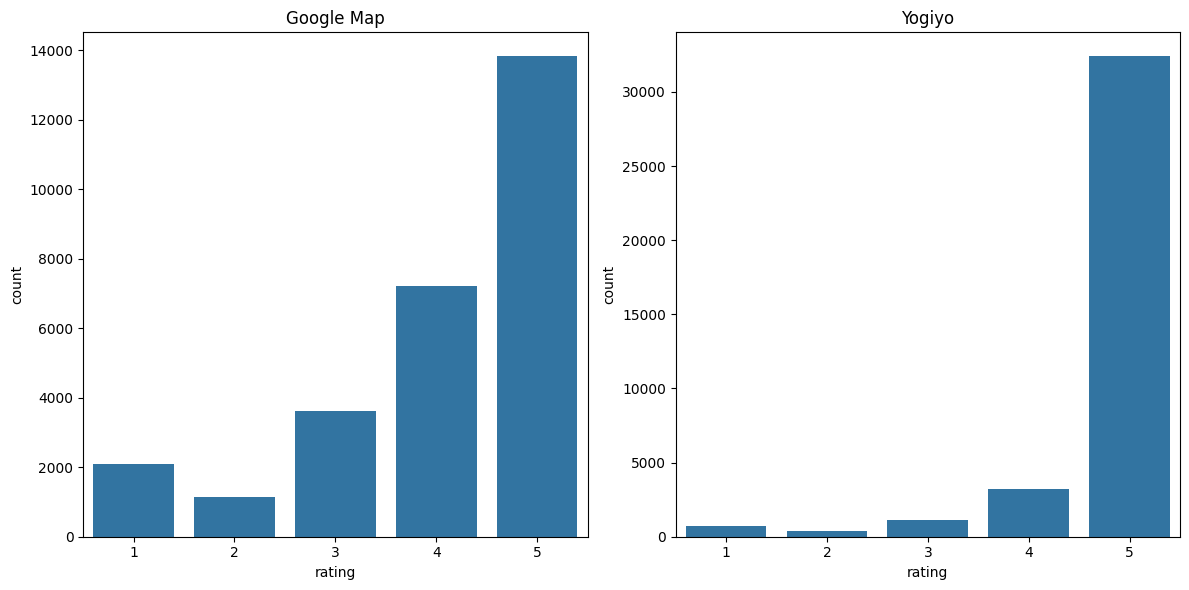

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x='rating', data=google_map_data, ax=axes[0])
sns.countplot(x='rating', data=yogiyo_data, ax=axes[1])
axes[0].set_title('Google Map')
axes[1].set_title('Yogiyo')

plt.tight_layout()
plt.show()

In [ ]:
google_store_count = google_map_data['store_name'].nunique()
google_review_count = len(google_map_data)

yogiyo_store_count = yogiyo_data['store_id'].nunique()
yogiyo_review_count = len(yogiyo_data)

# 구글 리뷰 데이터의 평균과 표준편차
google_mean = google_map_data['rating'].mean()
google_std = google_map_data['rating'].std()

# 요기요 리뷰 데이터의 평균과 표준편차
yogiyo_mean = yogiyo_data['rating'].mean()
yogiyo_std = yogiyo_data['rating'].std()

summary_data = {
    "플랫폼": ["요기요", "구글"],
    "가게 수": [yogiyo_store_count, google_store_count],
    "리뷰 수": [yogiyo_review_count, google_review_count],
    "평점 평균": [yogiyo_mean, google_mean],
    "평점 편차": [yogiyo_std, google_std]
}

summary_df = pd.DataFrame(summary_data)
summary_df

,플랫폼,가게 수,리뷰 수,평점 평균,평점 편차
0,요기요,22,37840,4.749683,0.731638
1,구글,2055,27893,4.060625,1.206763


In [ ]:
#특수문자 제거 + 자음, 모음만 있는 것 제거 + 공백 여러 개를 하나의 공백으로
#df = pd.read_csv("/content/drive/MyDrive/google_map_review_final.csv")
import re
def clean_text(text):
  # 특수문자 제거
  text = re.sub(r'[^\w\s]', '', text)
  # 자음, 모음만 있는 것 제거
  text = re.sub(r'\b[ㄱ-ㅎㅏ-ㅣ]+\b', '', text)
  # 공백 여러 개를 하나의 공백으로 변환
  text = re.sub(r'\s+', ' ', text).strip()
  return text
#df['comment'] = df['comment'].apply(lambda x: clean_text(x) if pd.notna(x) else x)
yogiyo_data['comment_'] = yogiyo_data['comment'].apply(lambda x: clean_text(x) if pd.notna(x) else x)

In [ ]:
#띄어쓰기 교정-PyKoSpacing
from pykospacing import Spacing
def correct_spacing(text):
  spacing = Spacing()
  corrected_text = spacing(text)
  return corrected_text
#df['comment'] = df['comment'].apply(lambda x: correct_spacing(x) if pd.notna(x) else x)
yogiyo_data['comment_'] = yogiyo_data['comment_'].apply(lambda x: correct_spacing(x) if pd.notna(x) else x)

In [ ]:
#SOYNLP을 이용한 반복되는 문자 제한
!pip install soynlp
from soynlp.normalizer import *

def exception(text):
  text = emoticon_normalize(text, num_repeats = 2)
  return text

#df['comment'] = df['comment'].apply(lambda x: exception(x) if pd.notna(x) else x)
yogiyo_data['comment_'] = yogiyo_data['comment_'].apply(lambda x: exception(x) if pd.notna(x) else x)

In [ ]:
!pip install konlpy

In [ ]:
from konlpy.tag import Okt
okt = Okt()
stop_words = set(['은', '는', '이', '가', '아', '하', '들', '것', '의', '있', '되', '수', '보', '주', '등', '한', '에'])

In [ ]:
def preprocessing(okt, review):
  # 한글이 아닌 단어는 지우고 " "으로 대체
  review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ]", " ", review)
  # 형태소 분석을 하며 stemming 기법을 사용
  token_li = okt.morphs(review_text, stem=True)
  # 이전 stop_words에 포함되지 않는 단어만 clean_review에 들어갈 수 있게 함
  clean_review = [token for token in token_li if not token in stop_words]
  clean_review = ' '.join(clean_review)
  return clean_review.strip()

#df['comment'] = df["comment"].apply(lambda x: preprocessing(okt, x))
yogiyo_data['comment_'] = yogiyo_data['comment_'].apply(lambda x: preprocessing(okt, x))

In [ ]:
yogiyo_data

In [ ]:
df.to_csv("/content/drive/MyDrive/preprocessed_google_map_review.csv")

In [ ]:
yogiyo_data.to_csv("/content/drive/MyDrive/preprocessed_yogiyo_review.csv")

## 2-2) 불균형 데이터 해소

In [ ]:
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--no-sandbox")
driver = webdriver.Chrome(options=options)

In [ ]:
# 역번역을 통한 데이터 증강
trans_list = []  # 중간 번역 저장
backtrans_list = []  # 최종 번역 결과 저장

from tqdm import tqdm

# kor_to_trans 함수: 한국어 -> 외국어
def kor_to_trans(text_data, trans_lang):
    global trans_list
    trans_list = []
    for i in tqdm(range(len(text_data))):
        try:
            driver.get('https://papago.naver.com/?sk=ko&tk='+trans_lang+'&st='+text_data[i])
            time.sleep(2.5)
            backtrans = driver.find_element(By.XPATH, '//*[@id="txtTarget"]').text
            trans_list.append(backtrans)
        except Exception as e:
            print(f"Error on index {i}: {e}")

# trans_to_kor 함수: 외국어 -> 한국어
def trans_to_kor(transed_list, transed_lang):
    global backtrans_list
    for i in tqdm(range(len(transed_list))):
        try:
            driver.get('https://papago.naver.com/?sk='+transed_lang+'&tk=ko&st='+transed_list[i])
            time.sleep(2.5)
            backtrans = driver.find_element(By.XPATH, '//*[@id="txtTarget"]').text
            backtrans_list.append(backtrans)
        except Exception as e:
            print(f"Error on index {i}: {e}")
            backtrans_list.append("")

languages = {
    1: ['en', 'ja&hn=0', 'zh-CN', 'fr'],
    2: ['en', 'ja&hn=0', 'zh-CN', 'fr'],
    3: ['en', 'ja&hn=0', 'zh-CN'],
    4: ['en', 'ja&hn=0'],
}

augmented_data = []
count = 0

df = pd.read_csv("/content/drive/MyDrive/preprocessed_google_map_review.csv")

for index, row in df.iterrows():
    rating = row['rating']
    comment = row['comment']
    count += 1
    print(f"#######{count}번######")
    if rating in languages:
        for lang in languages[rating]:
            # 한국어 -> 외국어 번역
            kor_to_trans([comment], lang)
            # 외국어 -> 한국어 번역
            trans_to_kor(trans_list, lang)
            # 결과 저장
            if backtrans_list:
                augmented_data.append({'rating': rating, 'comment': backtrans_list[-1]})
            else:
                augmented_data.append({'rating': rating, 'comment': comment})

augmented_df = pd.DataFrame(augmented_data)
df_expanded = augmented_df
driver.quit()

In [ ]:
combined_df = df_expanded
combined_df.to_csv("/content/drive/MyDrive/preprocessed_google_map_review+역번역_전체.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


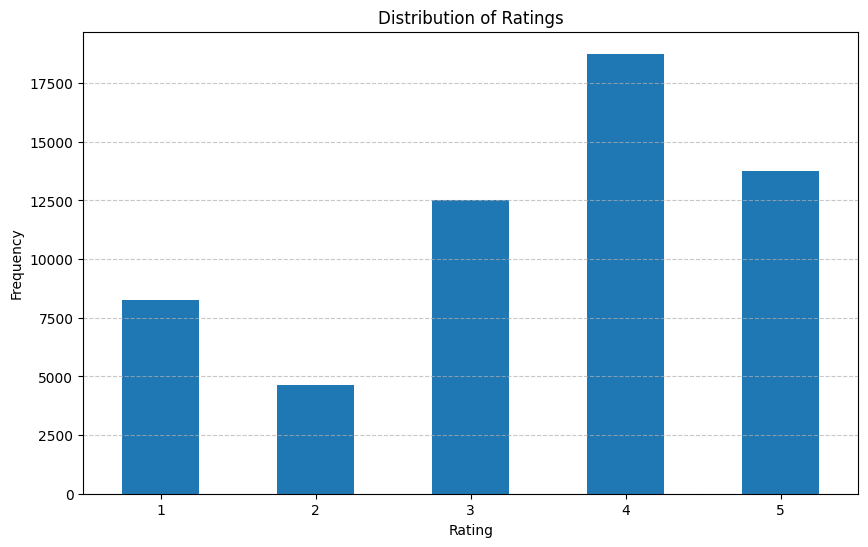

In [ ]:
# 역번역이 수행된 이후 분포 변화 확인
plt.figure(figsize=(10, 6))
combined_df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
combined_df = pd.read_csv("/content/drive/MyDrive/preprocessed_google_map_review+역번역_전체.csv")

In [ ]:
#EDA
import random
import pickle
import pandas as pd
from google.colab import drive

# Google 드라이브 마운트
drive.mount('/content/drive')
wordnet_path = '/content/drive/MyDrive/wordnet.pickle'

wordnet = {}

def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return new_words if len(new_words) != 0 else []

def get_synonyms(word):
    synonyms = []
    try:
        for syn in wordnet[word]:
            for s in syn:
                synonyms.append(s)
    except KeyError:
        pass
    return synonyms

def random_deletion(words, p):
    if len(words) == 1:
        return words
    new_words = [word for word in words if random.uniform(0, 1) > p]
    return new_words if len(new_words) != 0 else [random.choice(words)]

def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words

def swap_word(new_words):
    if len(new_words) < 2:
        return new_words
    idx1, idx2 = random.sample(range(len(new_words)), 2)
    new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return new_words

def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words

def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1 and counter < 10:
        random_word = random.choice(new_words)
        synonyms = get_synonyms(random_word)
        counter += 1
    if synonyms:
        random_synonym = random.choice(synonyms)
        random_idx = random.randint(0, len(new_words))
        new_words.insert(random_idx, random_synonym)

# EDA 적용 함수
def EDA(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
    words = sentence.split(' ')
    words = [word for word in words if word]
    num_words = len(words)

    augmented_sentences = []
    num_new_per_technique = int(num_aug / 4) + 1

    n_sr = max(1, int(alpha_sr * num_words))
    n_ri = max(1, int(alpha_ri * num_words))
    n_rs = max(1, int(alpha_rs * num_words))

    # Synonym replacement
    for _ in range(num_new_per_technique):
        a_words = synonym_replacement(words, n_sr)
        augmented_sentences.append(' '.join(a_words))

    # Random insertion
    for _ in range(num_new_per_technique):
        a_words = random_insertion(words, n_ri)
        augmented_sentences.append(' '.join(a_words))

    # Random swap
    for _ in range(num_new_per_technique):
        a_words = random_swap(words, n_rs)
        augmented_sentences.append(" ".join(a_words))

    # Random deletion
    for _ in range(num_new_per_technique):
        a_words = random_deletion(words, p_rd)
        augmented_sentences.append(" ".join(a_words))

    random.shuffle(augmented_sentences)

    if num_aug >= 1:
        augmented_sentences = augmented_sentences[:num_aug]
    else:
        keep_prob = num_aug / len(augmented_sentences)
        augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

    augmented_sentences.append(sentence)
    return augmented_sentences

# DataFrame에 EDA 적용 함수
def apply_eda_to_dataframe_v2(df, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1):
    # 최종 결과를 담을 리스트
    augmented_data = []

    for _, row in df.iterrows():
        comment = row['comment']
        rating = row['rating']

        # 증강 배수 설정
        if rating == 1:
            num_aug = 2  # 1인 경우 2배 증강
        elif rating == 2:
            num_aug = 2  # 2인 경우 2배 증강
        else:
            continue  # 나머지는 증강하지 않음

        # EDA 적용
        augmented_comments = EDA(comment, alpha_sr, alpha_ri, alpha_rs, p_rd, num_aug)

        for augmented_comment in augmented_comments:
            augmented_data.append({'comment': augmented_comment, 'rating': rating})

    augmented_df = pd.DataFrame(augmented_data)
    return augmented_df

df = combined_df
result_df = apply_eda_to_dataframe_v2(df)
result_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,comment,rating
0,거리의 한 장소,2
1,거리의 장소,2
2,거리의 한 장소,2
3,거리의 위치,2
4,거리의 위치,2
...,...,...
38572,주차도 인심 못하는,1
38573,주차도 못하는 인심,1
38574,주차도 못하다,1
38575,못하다 주차도,1


In [ ]:
df = pd.concat([result_df, combined_df])

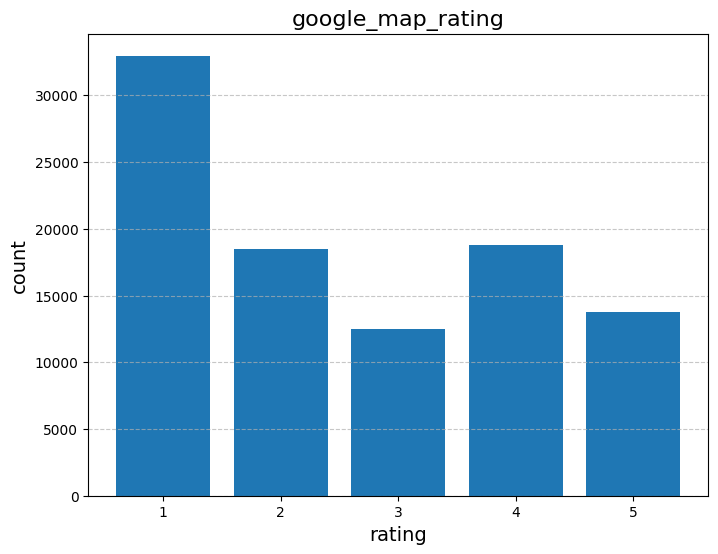

In [ ]:
import matplotlib.pyplot as plt
#EDA이후의 분포 그래프로 나타내기
# 별점 분포 계산
rating_distribution = df['rating'].value_counts().sort_index()

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(rating_distribution.index, rating_distribution.values)
plt.title('google_map_rating', fontsize=16)
plt.xlabel('rating', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(rating_distribution.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# 별점 비율 계산
rating_percentage = (df['rating'].value_counts(normalize=True) * 100).sort_index()

# 비율 출력
for rating, percentage in rating_percentage.items():
    print(f"Rating {rating}: {percentage:.2f}%")

Rating 1: 34.18%
Rating 2: 19.15%
Rating 3: 12.98%
Rating 4: 19.45%
Rating 5: 14.25%


In [ ]:
#swap
# 결측값 제거
google_data_cleaned = df
google_data_cleaned = google_data_cleaned.dropna(subset=['comment'])

# 모든 값을 문자열로 변환
google_data_cleaned['comment'] = google_data_cleaned['comment'].astype(str)

# random_swap 함수 및 증강 함수 유지
def augment_text_with_swap(text, num_augments=1):
    if not isinstance(text, str):  # 데이터가 문자열인지 확인
        return []
    words = text.split()  # 문장을 단어 단위로 분리
    augmented_texts = []

    for _ in range(num_augments):
        augmented_text = random_swap(words, n=2)  # 2번 교환 수행
        augmented_texts.append(" ".join(augmented_text))  # 증강된 텍스트를 문자열로 변환

    return augmented_texts

# 중복된 comment 제거
unique_google_data = google_data_cleaned.drop_duplicates(subset=['comment'])

# 증강된 데이터 생성
augmented_google_comments = []
augmented_ratings = []
augmented_store_names = []
augmentation_factor = 1

for _, row in unique_google_data.iterrows():
    comment = row['comment']
    rating = row['rating']

    # 원본 데이터 포함
    augmented_google_comments.append(comment)
    augmented_ratings.append(rating)

    # 증강 데이터 추가
    augmented_comments = augment_text_with_swap(comment, num_augments=augmentation_factor)
    augmented_google_comments.extend(augmented_comments)
    augmented_ratings.extend([rating] * len(augmented_comments))

# 새로운 데이터프레임 생성
augmented_google_data_cleaned = pd.DataFrame({
    'comment': augmented_google_comments,
    'rating': augmented_ratings
})

# 증강된 데이터 확인
print(f"Original Google Data Shape: {google_data_cleaned.shape}")
print(f"Augmented Data Shape (After Deduplication): {augmented_google_data_cleaned.shape}")
print(augmented_google_data_cleaned.head())


Original Google Data Shape: (96447, 4)
Augmented Data Shape (After Deduplication): (119278, 2)
    comment  rating
0  거리의 한 장소       2
1  한 장소 거리의       2
2    거리의 장소       2
3    거리의 장소       2
4    거리의 위치       2


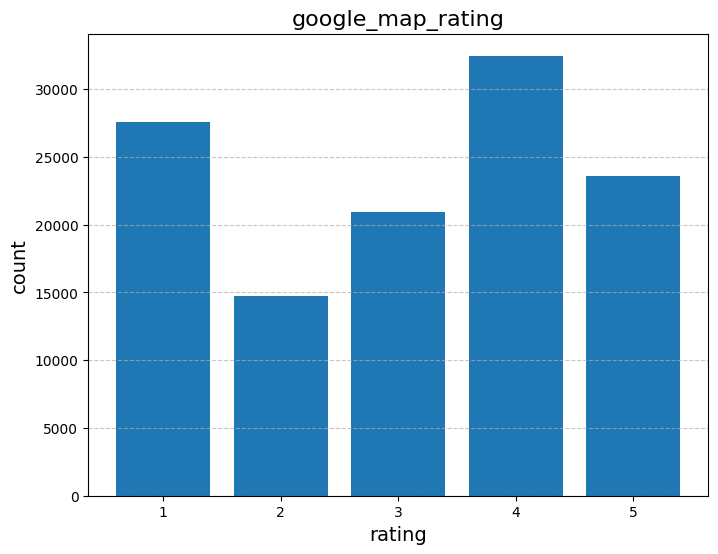

Rating 1: 23.12%
Rating 2: 12.35%
Rating 3: 17.53%
Rating 4: 27.22%
Rating 5: 19.78%


In [ ]:
#swap 이후 변화
import matplotlib.pyplot as plt
df = augmented_google_data_cleaned
# 별점 분포 계산
rating_distribution = df['rating'].value_counts().sort_index()

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(rating_distribution.index, rating_distribution.values)
plt.title('google_map_rating', fontsize=16)
plt.xlabel('rating', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(rating_distribution.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
# 별점 비율 계산
rating_percentage = (df['rating'].value_counts(normalize=True) * 100).sort_index()

# 비율 출력
for rating, percentage in rating_percentage.items():
    print(f"Rating {rating}: {percentage:.2f}%")

In [ ]:
# 비율
rating_ratio = [f"{round(percentage):.0f}" for percentage in rating_percentage]

# 비율 출력
print("Rating Ratios: " + ":".join(rating_ratio))

Rating Ratios: 23:12:18:27:20


# 모델 학습

##  TF-IDF->Random Forest



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Mounted at /content/drive


In [ ]:
combined_df = pd.read_csv("/content/drive/MyDrive/preprocess+translate+eda+swap.csv")
x = combined_df['comment']
y = combined_df['rating']

tfidf_vectorizer = TfidfVectorizer()
x = tfidf_vectorizer.fit_transform(x)
X_train_resampled, X_test, y_train_resampled,y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train_resampled,y_train_resampled)
pred = rf.predict(X_test)

# 훈련 세트에 대한 성능 평가
train_pred = rf.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, train_pred)
print("훈련 세트 성능 평가 지표:")
print(f"Train Accuracy (정확도): {train_accuracy:.4f}")
print("\nTrain Classification Report:")
print(classification_report(y_train_resampled, train_pred))

# 테스트 세트에 대한 성능 평가
test_pred = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
print("\n테스트 세트 성능 평가 지표:")
print(f"Test Accuracy (정확도): {test_accuracy:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, test_pred))

훈련 세트 성능 평가 지표:
Train Accuracy (정확도): 0.9877

Train Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99     21975
           2       0.99      0.98      0.99     11763
           3       0.99      0.98      0.99     16765
           4       0.99      0.99      0.99     26043
           5       0.97      0.99      0.98     18876

    accuracy                           0.99     95422
   macro avg       0.99      0.99      0.99     95422
weighted avg       0.99      0.99      0.99     95422


테스트 세트 성능 평가 지표:
Test Accuracy (정확도): 0.9231

Test Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.97      0.96      5601
           2       0.96      0.94      0.95      2963
           3       0.94      0.84      0.89      4149
           4       0.91      0.90      0.91      6423
           5       0.86      0.95      0.90      4720

    accuracy                       

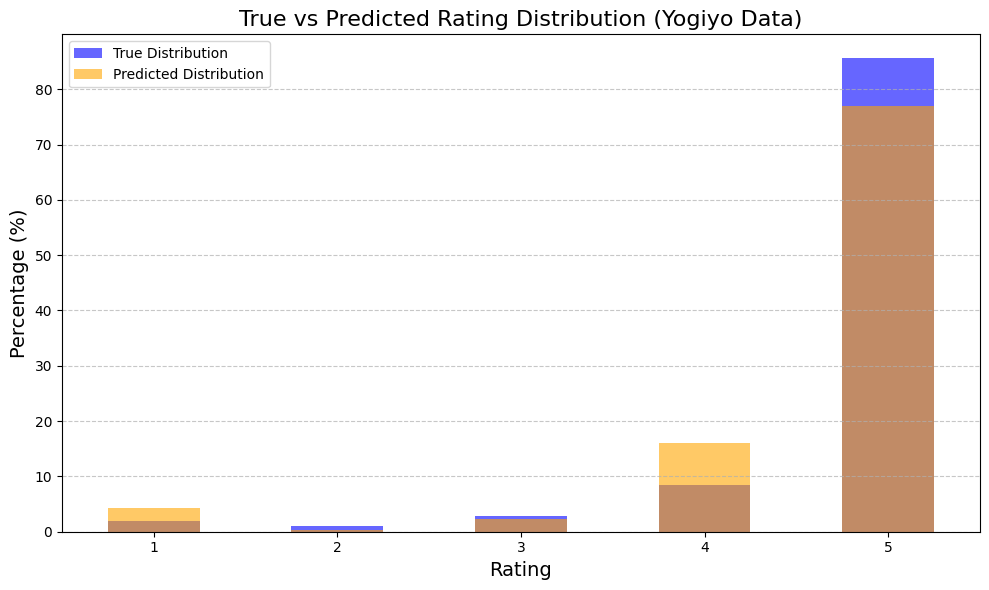

True Distribution (%):
rating
1     1.896932
2     1.048235
3     2.894618
4     8.516242
5    85.643973
Name: proportion, dtype: float64

Predicted Distribution (%):
1     4.280735
2     0.396414
3     2.303988
4    16.109293
5    76.909570
Name: proportion, dtype: float64


In [ ]:
yogiyo_data = pd.read_csv("/content/drive/MyDrive/preprocessed_yogiyo_review.csv")
yogiyo_data.dropna(inplace = True)
yogiyo_data.to_csv("/content/drive/MyDrive/preprocessed_yogiyo_review.csv")
x = yogiyo_data['comment']
y = yogiyo_data['rating']

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

x = tfidf_vectorizer.transform(x)
y_yogiyo_pred = rf.predict(x)

# 정답값 분포 계산
true_distribution_yogiyo = y.value_counts(normalize=True) * 100

# 예측값 분포 계산
pred_distribution_yogiyo = pd.Series(y_yogiyo_pred).value_counts(normalize=True) * 100

# 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 6))

# 실제 값 분포
true_distribution_yogiyo.sort_index().plot(kind='bar', alpha=0.6, color='blue', label='True Distribution', ax=ax)

# 예측 값 분포
pred_distribution_yogiyo.sort_index().plot(kind='bar', alpha=0.6, color='orange', label='Predicted Distribution', ax=ax)

plt.title("True vs Predicted Rating Distribution (Yogiyo Data)", fontsize=16)
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

# 분포 출력
print("True Distribution (%):")
print(true_distribution_yogiyo.sort_index())

print("\nPredicted Distribution (%):")
print(pred_distribution_yogiyo.sort_index())


In [ ]:
# 정확도 계산
accuracy = accuracy_score(y, y_yogiyo_pred)

# 정확도 출력
print(f"Accuracy Score: {accuracy:.4f}")

Accuracy Score: 0.7283


In [ ]:
yogiyo = pd.read_csv("/content/drive/MyDrive/yogigyo_Review_data.csv")

In [ ]:
incorrect_indices = np.where(y_yogiyo_pred != y)[0]
correct_indices = np.where(y_yogiyo_pred == y)[0]

index_incorrect = [yogiyo_data['Unnamed: 0'][i] for i in incorrect_indices]
index_correct = [yogiyo_data['Unnamed: 0'][i] for i in correct_indices]

In [ ]:
incorrect_results = pd.DataFrame({
    'Index': incorrect_indices,
    'Actual': y.iloc[incorrect_indices].values,
    'Predicted': y_yogiyo_pred[incorrect_indices],
    'Comment_preprocessing': [list(yogiyo_data['comment'][i]) for i in incorrect_indices],
    'Comment': [list(yogiyo['comment'][i]) for i in index_incorrect]
})

correct_results = pd.DataFrame({
    'Index': correct_indices,
    'Actual': y.iloc[correct_indices].values,
    'Predicted': y_yogiyo_pred[correct_indices],
    'Comment_preprocessing': [list(yogiyo_data['comment'][i]) for i in correct_indices],
    'Comment': [list(yogiyo['comment'][i]) for i in index_correct]
})

In [ ]:
incorrect_results.to_csv('/content/drive/MyDrive/incorrect_predictions_yogiyo.csv', index=False)
correct_results.to_csv('/content/drive/MyDrive/correct_predictions_yogiyo.csv', index=False)

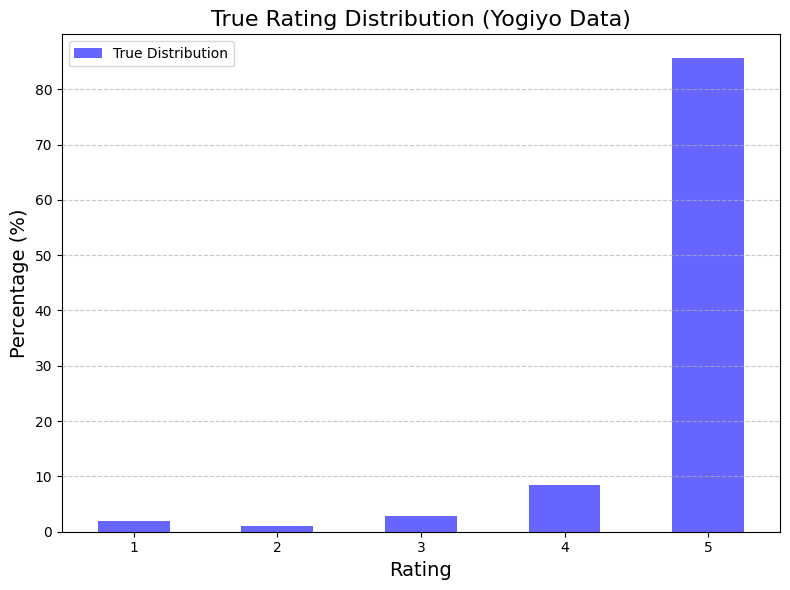

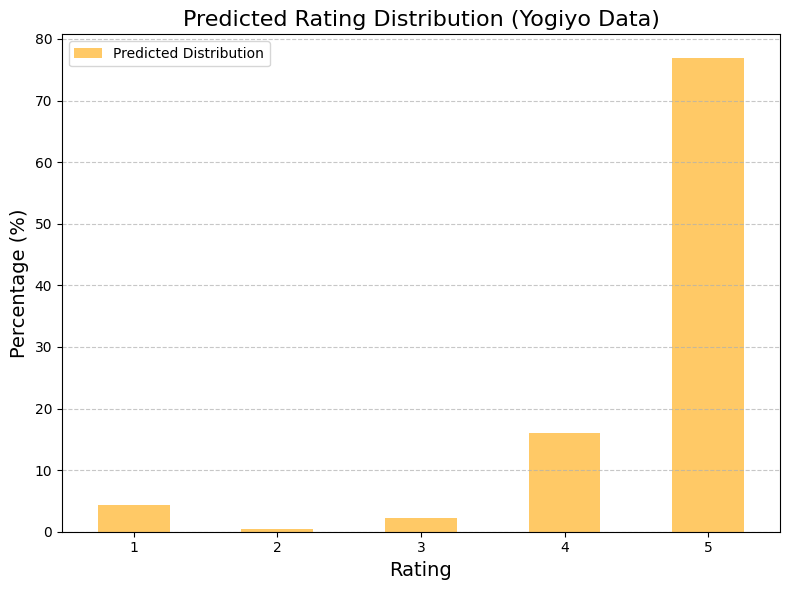

True Distribution (%):
rating
1     1.896932
2     1.048235
3     2.894618
4     8.516242
5    85.643973
Name: proportion, dtype: float64

Predicted Distribution (%):
1     4.280735
2     0.396414
3     2.303988
4    16.109293
5    76.909570
Name: proportion, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

# 그래프 1: 실제 값 분포
fig, ax1 = plt.subplots(figsize=(8, 6))
true_distribution_yogiyo.sort_index().plot(kind='bar', alpha=0.6, color='blue', label='True Distribution', ax=ax1)
ax1.set_title("True Rating Distribution (Yogiyo Data)", fontsize=16)
ax1.set_xlabel("Rating", fontsize=14)
ax1.set_ylabel("Percentage (%)", fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 그래프 2: 예측 값 분포
fig, ax2 = plt.subplots(figsize=(8, 6))
pred_distribution_yogiyo.sort_index().plot(kind='bar', alpha=0.6, color='orange', label='Predicted Distribution', ax=ax2)
ax2.set_title("Predicted Rating Distribution (Yogiyo Data)", fontsize=16)
ax2.set_xlabel("Rating", fontsize=14)
ax2.set_ylabel("Percentage (%)", fontsize=14)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 분포 출력
print("True Distribution (%):")
print(true_distribution_yogiyo.sort_index())

print("\nPredicted Distribution (%):")
print(pred_distribution_yogiyo.sort_index())


## TF-IDF -> lightgbm

In [ ]:
import lightgbm as lgb

combined_df = pd.read_csv("/content/drive/MyDrive/preprocess+translate+eda+swap.csv")
x = combined_df['comment']
y = combined_df['rating']

tfidf_vectorizer_lgb = TfidfVectorizer()
x = tfidf_vectorizer_lgb.fit_transform(x)
X_train_resampled, X_test, y_train_resampled,y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

lgb = lgb.LGBMClassifier(random_state = 42)
lgb.fit(X_train_resampled, y_train_resampled)
y_pred = lgb.predict(X_test)
# 훈련 세트에 대한 성능 평가
train_pred = rf.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, train_pred)
print("훈련 세트 성능 평가 지표:")
print(f"Train Accuracy (정확도): {train_accuracy:.4f}")
print("\nTrain Classification Report:")
print(classification_report(y_train_resampled, train_pred))

# 테스트 세트에 대한 성능 평가
test_pred = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
print("\n테스트 세트 성능 평가 지표:")
print(f"Test Accuracy (정확도): {test_accuracy:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, test_pred))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 11.989022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183083
[LightGBM] [Info] Number of data points in the train set: 95422, number of used features: 5641
[LightGBM] [Info] Start training from score -1.468404
[LightGBM] [Info] Start training from score -2.093350
[LightGBM] [Info] Start training from score -1.739016
[LightGBM] [Info] Start training from score -1.298560
[LightGBM] [Info] Start training from score -1.620418
훈련 세트 성능 평가 지표:
Train Accuracy (정확도): 0.9877

Train Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99     21975
           2       0.99      0.98      0.99     11763
           3       0.99      0.98      0.99     16765
           4       0.99      0.99      0.99     26043
           5       0.97      0.99      0.98     18876

    accuracy                       

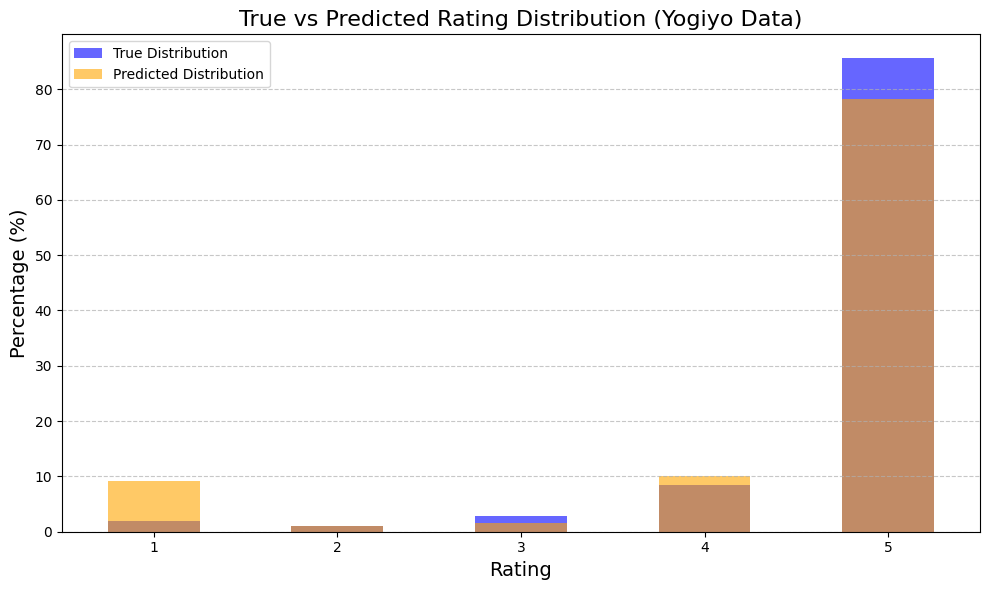

True Distribution (%):
rating
1     1.896932
2     1.048235
3     2.894618
4     8.516242
5    85.643973
Name: proportion, dtype: float64

Predicted Distribution (%):
1     9.229255
2     0.965759
3     1.489877
4    10.099236
5    78.215873
Name: proportion, dtype: float64


In [ ]:
yogiyo_data = pd.read_csv("/content/drive/MyDrive/preprocessed_yogiyo_review.csv")
yogiyo_data.dropna(inplace = True)
yogiyo_data.to_csv("/content/drive/MyDrive/preprocessed_yogiyo_review.csv")
x = yogiyo_data['comment']
y = yogiyo_data['rating']

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

x = tfidf_vectorizer_lgb.transform(x)
y_yogiyo_pred = lgb.predict(x)

# 정답값 분포 계산
true_distribution_yogiyo = y.value_counts(normalize=True) * 100

# 예측값 분포 계산
pred_distribution_yogiyo = pd.Series(y_yogiyo_pred).value_counts(normalize=True) * 100

# 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 6))

# 실제 값 분포
true_distribution_yogiyo.sort_index().plot(kind='bar', alpha=0.6, color='blue', label='True Distribution', ax=ax)

# 예측 값 분포
pred_distribution_yogiyo.sort_index().plot(kind='bar', alpha=0.6, color='orange', label='Predicted Distribution', ax=ax)

plt.title("True vs Predicted Rating Distribution (Yogiyo Data)", fontsize=16)
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

# 분포 출력
print("True Distribution (%):")
print(true_distribution_yogiyo.sort_index())

print("\nPredicted Distribution (%):")
print(pred_distribution_yogiyo.sort_index())


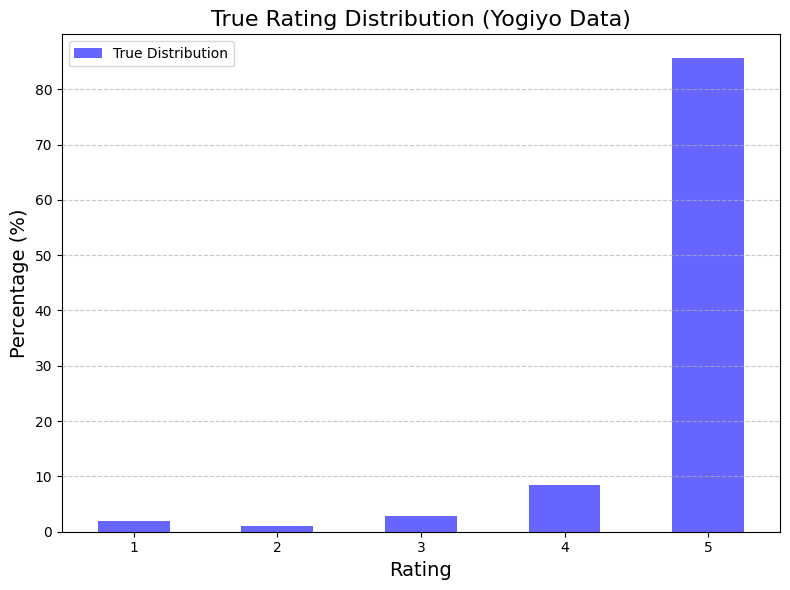

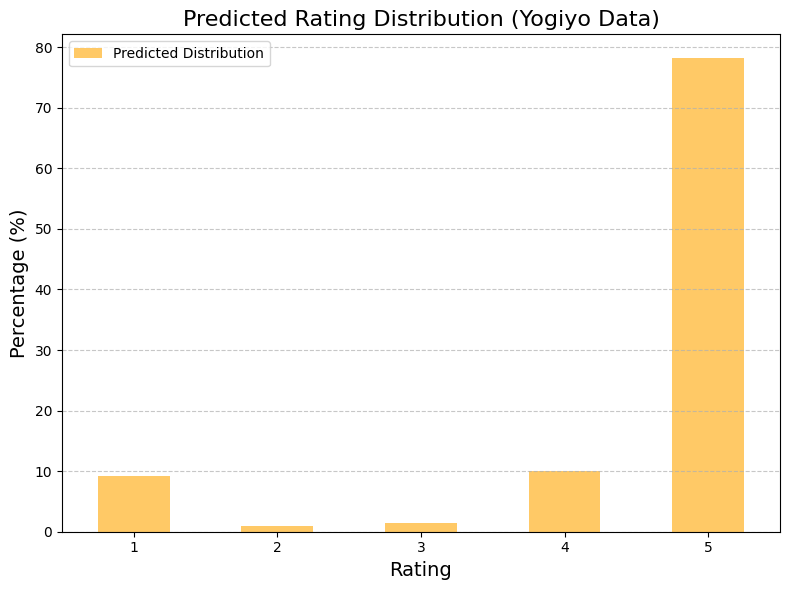

Accuracy Score: 0.7577
True Distribution (%):
rating
1     1.896932
2     1.048235
3     2.894618
4     8.516242
5    85.643973
Name: proportion, dtype: float64

Predicted Distribution (%):
1     9.229255
2     0.965759
3     1.489877
4    10.099236
5    78.215873
Name: proportion, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 그래프 1: 실제 값 분포
fig, ax1 = plt.subplots(figsize=(8, 6))
true_distribution_yogiyo.sort_index().plot(kind='bar', alpha=0.6, color='blue', label='True Distribution', ax=ax1)
ax1.set_title("True Rating Distribution (Yogiyo Data)", fontsize=16)
ax1.set_xlabel("Rating", fontsize=14)
ax1.set_ylabel("Percentage (%)", fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 그래프 2: 예측 값 분포
fig, ax2 = plt.subplots(figsize=(8, 6))
pred_distribution_yogiyo.sort_index().plot(kind='bar', alpha=0.6, color='orange', label='Predicted Distribution', ax=ax2)
ax2.set_title("Predicted Rating Distribution (Yogiyo Data)", fontsize=16)
ax2.set_xlabel("Rating", fontsize=14)
ax2.set_ylabel("Percentage (%)", fontsize=14)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Accuracy Score 계산
accuracy = accuracy_score(y, y_yogiyo_pred)
print(f"Accuracy Score: {accuracy:.4f}")

# 분포 출력
print("True Distribution (%):")
print(true_distribution_yogiyo.sort_index())

print("\nPredicted Distribution (%):")
print(pred_distribution_yogiyo.sort_index())


## Naive Bayes(NB)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 데이터 로드
google_data = pd.read_csv("/content/drive/MyDrive/preprocess+translate+eda+swap.csv")
yogiyo_data = pd.read_csv("/content/drive/MyDrive/preprocessed_yogiyo_review.csv")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

x = google_data['comment']
y = google_data['rating']

tfidf_vectorizer = TfidfVectorizer()
x = tfidf_vectorizer.fit_transform(x)

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# 구글 데이터만 학습시킨 경우

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# 나이브 베이즈 모델 생성 및 학습
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# 학습 데이터 성능 평가
y_train_pred = nb_model.predict(X_train)
print("학습 데이터 모델 성능 평가:")
print(classification_report(y_train, y_train_pred))
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"학습 데이터 Accuracy: {train_accuracy * 100:.2f}%")

# 테스트 데이터 성능 평가
y_test_pred = nb_model.predict(X_test)
print("\n테스트 데이터 모델 성능 평가:")
print(classification_report(y_test, y_test_pred))
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"테스트 데이터 Accuracy: {test_accuracy * 100:.2f}%")

학습 데이터 모델 성능 평가:
              precision    recall  f1-score   support

           1       0.80      0.86      0.83     21975
           2       0.98      0.44      0.61     11763
           3       0.89      0.45      0.60     16765
           4       0.69      0.69      0.69     26043
           5       0.56      0.95      0.71     18876

    accuracy                           0.71     95422
   macro avg       0.78      0.68      0.69     95422
weighted avg       0.76      0.71      0.70     95422

학습 데이터 Accuracy: 70.94%

테스트 데이터 모델 성능 평가:
              precision    recall  f1-score   support

           1       0.76      0.83      0.79      5601
           2       0.95      0.37      0.53      2963
           3       0.80      0.34      0.48      4149
           4       0.63      0.65      0.64      6423
           5       0.54      0.94      0.69      4720

    accuracy                           0.66     23856
   macro avg       0.74      0.63      0.63     23856
weighted avg     

In [ ]:
# NaN 값을 가진 행 삭제
yogiyo_data = yogiyo_data.dropna(subset=['comment'])

# 학습 데이터 (구글 데이터)
x_train = google_data['comment']
y_train = google_data['rating']

# 테스트 데이터 (요기요 데이터)
x_test = yogiyo_data['comment']
y_test = yogiyo_data['rating']

# TfidfVectorizer 학습
tfidf_vectorizer = TfidfVectorizer()
X_train_vec = tfidf_vectorizer.fit_transform(x_train)  # 학습 데이터에 대해서 fit_transform

# 나이브 베이즈 모델 학습
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# 학습 데이터에 대한 성능 평가
y_train_pred = nb_model.predict(X_train_vec)
print("학습 데이터 모델 성능 평가:")
print(classification_report(y_train, y_train_pred))
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"학습 데이터 Accuracy: {train_accuracy * 100:.2f}%")

학습 데이터 모델 성능 평가:
              precision    recall  f1-score   support

           1       0.82      0.86      0.84     27576
           2       0.97      0.49      0.65     14726
           3       0.89      0.48      0.62     20914
           4       0.71      0.69      0.70     32466
           5       0.56      0.96      0.71     23596

    accuracy                           0.72    119278
   macro avg       0.79      0.69      0.70    119278
weighted avg       0.77      0.72      0.71    119278

학습 데이터 Accuracy: 71.72%


In [ ]:
# 테스트 데이터에 대해서는 학습한 tfidf_vectorizer로 변환
X_test_vec = tfidf_vectorizer.transform(x_test)

# 테스트 데이터에 대한 성능 평가
y_test_pred = nb_model.predict(X_test_vec)
print("\n테스트 데이터 모델 성능 평가:")
print(classification_report(y_test, y_test_pred))
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"테스트 데이터 Accuracy: {test_accuracy * 100:.2f}%")


테스트 데이터 모델 성능 평가:
              precision    recall  f1-score   support

           1       0.31      0.42      0.35       713
           2       0.11      0.01      0.01       394
           3       0.26      0.03      0.05      1088
           4       0.20      0.12      0.15      3201
           5       0.88      0.95      0.91     32191

    accuracy                           0.83     37587
   macro avg       0.35      0.30      0.30     37587
weighted avg       0.79      0.83      0.80     37587

테스트 데이터 Accuracy: 83.03%


## SVM (Support Vector Machine)

In [ ]:
import pandas as pd
import numpy as np
import ast
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 구글 데이터만 학습시킨 경우

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# SVM 모델 생성 및 학습
svm_model = SVC()
svm_model.fit(X_train, y_train)

# 학습 데이터 성능 평가
y_train_pred = svm_model.predict(X_train)
print("학습 데이터 모델 성능 평가:")
print(classification_report(y_train, y_train_pred))
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"학습 데이터 Accuracy: {train_accuracy * 100:.2f}%")

# 테스트 데이터 성능 평가
y_test_pred = svm_model.predict(X_test)
print("\n테스트 데이터 모델 성능 평가:")
print(classification_report(y_test, y_test_pred))
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"테스트 데이터 Accuracy: {test_accuracy * 100:.2f}%")

학습 데이터 모델 성능 평가:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99     21975
           2       0.98      0.96      0.97     11763
           3       0.97      0.93      0.95     16765
           4       0.96      0.95      0.95     26043
           5       0.91      0.98      0.94     18876

    accuracy                           0.96     95422
   macro avg       0.96      0.96      0.96     95422
weighted avg       0.96      0.96      0.96     95422

학습 데이터 Accuracy: 96.13%

테스트 데이터 모델 성능 평가:
              precision    recall  f1-score   support

           1       0.94      0.96      0.95      5601
           2       0.95      0.90      0.93      2963
           3       0.90      0.77      0.83      4149
           4       0.84      0.86      0.85      6423
           5       0.83      0.91      0.87      4720

    accuracy                           0.88     23856
   macro avg       0.89      0.88      0.88     23856
weighted avg     

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# 학습 데이터 (구글 데이터)
x_train = google_data['comment']
y_train = google_data['rating']


# 학습 데이터에 TF-IDF 변환 적용
tfidf_vectorizer = TfidfVectorizer()
X_train_vec = tfidf_vectorizer.fit_transform(x_train)

# SVM 모델
svm_model = SVC(C=1.0)

# 구글 데이터로 학습
svm_model.fit(X_train_vec, y_train)

# 학습 데이터 성능 평가
y_train_pred = svm_model.predict(X_train_vec)
print("학습 데이터 모델 성능 평가:")
print(classification_report(y_train, y_train_pred))
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"학습 데이터 Accuracy: {train_accuracy * 100:.2f}%")

학습 데이터 모델 성능 평가:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99     27576
           2       0.98      0.97      0.98     14726
           3       0.98      0.95      0.96     20914
           4       0.97      0.96      0.96     32466
           5       0.93      0.98      0.95     23596

    accuracy                           0.97    119278
   macro avg       0.97      0.97      0.97    119278
weighted avg       0.97      0.97      0.97    119278

학습 데이터 Accuracy: 96.87%


In [ ]:
# 테스트 데이터 (요기요 데이터)
x_test = yogiyo_data['comment']
y_test = yogiyo_data['rating']

# NaN 값을 가진 행 삭제
yogiyo_data = yogiyo_data.dropna(subset=['comment'])

# 테스트 데이터에 TF-IDF 변환 적용
X_test_vec = tfidf_vectorizer.transform(x_test)

# 모델 예측 (요기요 데이터에 대한 예측)
y_pred_yogiyo = svm_model.predict(X_test_vec)

# 요기요 데이터 성능 평가
print("\n요기요 데이터 모델 성능 평가:")
print(classification_report(y_test, y_pred_yogiyo))

# 예측된 평점 확인
yogiyo_data['predicted_rating'] = y_pred_yogiyo
print("예측된 평점 (요기요):")
print(yogiyo_data[['comment', 'predicted_rating']].head())

# 정확도(Accuracy) 평가
accuracy = accuracy_score(y_test, y_pred_yogiyo)
print(f'Accuracy: {accuracy * 100:.2f}%')


요기요 데이터 모델 성능 평가:
              precision    recall  f1-score   support

           1       0.27      0.75      0.40       713
           2       0.07      0.07      0.07       394
           3       0.16      0.21      0.18      1088
           4       0.16      0.25      0.20      3201
           5       0.92      0.83      0.87     32191

    accuracy                           0.75     37587
   macro avg       0.32      0.42      0.34     37587
weighted avg       0.82      0.75      0.78     37587

예측된 평점 (요기요):
                                   comment  predicted_rating
0  뿌링클 언제나 맛있다 해 요 소스 오래되다 건지다 젤리 처럼 굳다 오다                 5
1                오늘 양념 을 더 넉넉하다 입히다 맛있다 먹다                 4
2                    넘다 비삭 비삭 게 맛 나다 자다 먹다                 5
3                           자다 받다 재다 예정 이다                 4
4             닭 뼈 만 있다 오랫동안 먹다 이렇다 닭 처음 예요                 5
Accuracy: 75.23%


## CNN

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/preprocess+translate+eda+swap.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = data.drop(columns=['Unnamed: 0'])

# 특성과 레이블 분리
texts = data['comment']
labels = data['rating']

# 학습 및 테스트 데이터 분리
texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42)

# 토큰화 및 시퀀스 변환
tokenizer = Tokenizer(num_words=20000)  # 상위 20,000개의 단어만 사용
tokenizer.fit_on_texts(texts_train)
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

# 패딩
max_sequence_length = 100  # 고정된 길이로 시퀀스를 패딩
x_train = pad_sequences(sequences_train, maxlen=max_sequence_length)
x_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

# 레이블 원-핫 인코딩
from tensorflow.keras.utils import to_categorical

num_classes = labels.nunique()
y_train = to_categorical(labels_train)
y_test = to_categorical(labels_test)


In [ ]:
y_train = y_train[:, 1:]
y_test = y_test[:, 1:]

In [ ]:
# Input layer
input_layer = Input(shape=(100,))

# Embedding layer
embedding_layer = Embedding(input_dim=20000, output_dim=50, input_length=100)(input_layer)

# Conv1D + GlobalMaxPooling layers
conv_layers = [Conv1D(128, kernel_size=5, activation='relu', padding='same')(embedding_layer)]
pooled_layers = [GlobalMaxPooling1D()(conv) for conv in conv_layers]

# Concatenate pooled outputs
concat_layer = Concatenate()(pooled_layers)

# Dropout and Dense layers
dropout_layer = Dropout(0.5)(concat_layer)
dense_layer = Dense(64, activation='relu')(dropout_layer)
output_layer = Dense(5, activation='softmax')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 50)             │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 100, 128)            │          32,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ concatenate (Concatenate)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,040,709 (3.97 MB)

 Trainable params: 1,040,709 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(x_train, y_train, epochs=20, validation_split=0.2,
                    callbacks=[checkpoint_cb, early_stopping_cb])

loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Epoch 1/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 92s 37ms/step - accuracy: 0.4801 - loss: 1.2113 - val_accuracy: 0.6473 - val_loss: 0.8615
Epoch 2/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 93s 39ms/step - accuracy: 0.6957 - loss: 0.7566 - val_accuracy: 0.7107 - val_loss: 0.7328
Epoch 3/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 136s 37ms/step - accuracy: 0.7704 - loss: 0.5774 - val_accuracy: 0.7321 - val_loss: 0.6898
Epoch 4/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 139s 35ms/step - accuracy: 0.8114 - loss: 0.4721 - val_accuracy: 0.7415 - val_loss: 0.6862
Epoch 5/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 130s 30ms/step - accuracy: 0.8355 - loss: 0.4080 - val_accuracy: 0.7540 - val_loss: 0.7003
Epoch 6/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step - accuracy: 0.8512 - loss: 0.3655 - val_accuracy: 0.7600 - val_loss: 0.7267
Epoch 7/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 80s 29ms/step - accuracy: 0.8663 - loss: 0.3275 - val_accuracy: 0.7585 - val_loss: 0.7660
746/746 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7367 - loss: 0.71

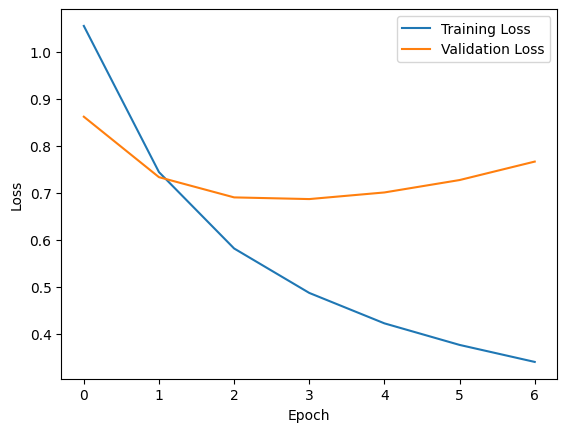

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## LSTM

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/preprocess+translate+eda+swap.csv")

Mounted at /content/drive


In [ ]:
data = data.drop(columns=['Unnamed: 0'])

texts = data['comment']
labels = data['rating']

texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
labels_train = labels_train - 1
labels_test = labels_test - 1

In [ ]:
# 텍스트 데이터 전처리
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(texts_train)
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

# 패딩
max_sequence_length = 100
x_train = pad_sequences(sequences_train, maxlen=max_sequence_length)
x_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

# 레이블 전처리
num_classes = len(set(labels))
y_train = to_categorical(labels_train, num_classes=num_classes)
y_test = to_categorical(labels_test, num_classes=num_classes)

# LSTM 모델 설계
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=max_sequence_length),
    LSTM(128, dropout=0.5, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2,
          callbacks=[checkpoint_cb, early_stopping_cb])

loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Epoch 1/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 556s 232ms/step - accuracy: 0.4965 - loss: 1.1788 - val_accuracy: 0.6366 - val_loss: 0.8979
Epoch 2/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 566s 234ms/step - accuracy: 0.6991 - loss: 0.7573 - val_accuracy: 0.7001 - val_loss: 0.7471
Epoch 3/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 559s 232ms/step - accuracy: 0.7619 - loss: 0.5998 - val_accuracy: 0.7315 - val_loss: 0.6868
Epoch 4/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 561s 235ms/step - accuracy: 0.7931 - loss: 0.5193 - val_accuracy: 0.7445 - val_loss: 0.6562
Epoch 5/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 561s 235ms/step - accuracy: 0.8145 - loss: 0.4609 - val_accuracy: 0.7569 - val_loss: 0.6573
Epoch 6/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 563s 236ms/step - accuracy: 0.8342 - loss: 0.4087 - val_accuracy: 0.7656 - val_loss: 0.6499
Epoch 7/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 619s 235ms/step - accuracy: 0.8489 - loss: 0.3732 - val_accuracy: 0.7734 - val_loss: 0.6613
Epoch 8/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 560s 234ms/step - ac

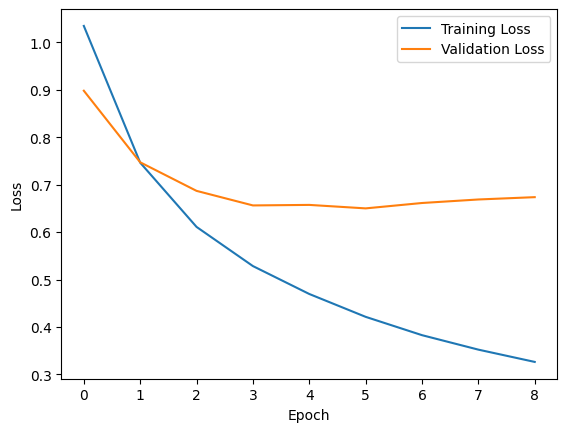

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# TF-IDF 키워드 추출

In [8]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 27.7 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
df1 = pd.read_csv("/content/drive/MyDrive/incorrect_predictions_yogiyo.csv")
df2 = pd.read_csv("/content/drive/MyDrive/correct_predictions_yogiyo.csv")

In [16]:
import ast  # 문자열을 리스트로 변환하는 데 사용

# 문자열 형태를 리스트로 변환 후 처리
def process_string_list(row):
    # 문자열을 리스트로 변환
    row = ast.literal_eval(row) if isinstance(row, str) else row
    # 리스트 요소 정리 (양쪽 작은따옴표와 공백 제거)
    # cleaned = [elem.strip(" '") for elem in row]
    return ''.join(row)  # 요소를 그대로 연결

# 데이터프레임에서 처리
df1['Comment'] = df1['Comment'].apply(process_string_list)
df2['Comment'] = df2['Comment'].apply(process_string_list)

<Axes: xlabel='Predicted', ylabel='Actual'>

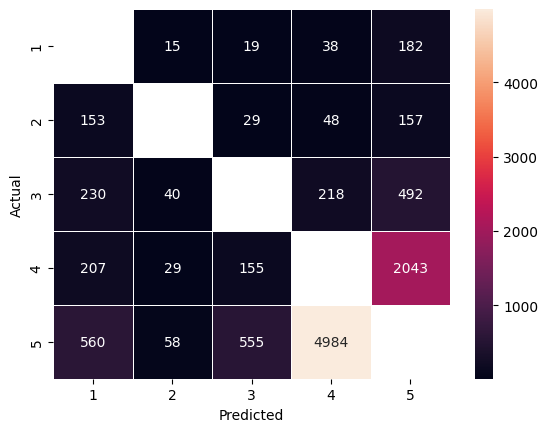

In [ ]:
count = df1.groupby(['Actual', 'Predicted']).size().reset_index(name='Count')

pivot_df = count.pivot(index='Actual', columns='Predicted', values='Count')

sns.heatmap(pivot_df, annot=True, fmt='g', linewidths=0.5)

In [17]:
incorrect_data1 = df1[(df1['Actual'] == 5) & (df1['Predicted'] == 4)]
incorrect_data2 = df1[(df1['Actual'] == 5) & (df1['Predicted'] == 3)]
incorrect_data3 = df1[(df1['Actual'] == 5) & (df1['Predicted'] == 2)]
incorrect_data4 = df1[(df1['Actual'] == 5) & (df1['Predicted'] == 1)]
incorrect_data = pd.concat([incorrect_data1, incorrect_data2, incorrect_data3, incorrect_data4])

In [18]:
correct_data = df2[(df2['Actual'] == 5) & (df2['Predicted'] == 5)]

In [70]:
import re
from collections import Counter
from konlpy.tag import Okt

# 형태소 분석기 초기화
okt = Okt()

stop_words = set(['은', '는', '이', '가', '아', '요', '하', '들', '것', '의', '있',
                  '되', '수', '보', '주', '등', '한', '에', '도', '뿌링클', '지점',
                  '치킨', 'bhc', '롯데리아', '배달', '양', '교촌'])

# 전처리 및 단어 추출 함수
def extract_tokens(text):
    # 한글과 공백만 남기고 나머지 제거
    cleaned_text = re.sub(r"[^가-힣\s]", "", text)
    # 단어 추출
    tokens = okt.morphs(cleaned_text, stem=True)
    # 불용어 제거
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

In [57]:
# incorrect data

# 모든 리뷰에서 단어 추출 및 병합
all_tokens = []
for comment in incorrect_data['Comment']:
    tokens = extract_tokens(comment)
    all_tokens.extend(tokens)

# 단어 빈도 계산
token_counter = Counter(all_tokens)

# 상위 빈도 단어 출력
top_words = token_counter.most_common(30)
print("전체 문서에서 가장 높은 빈도의 단어 (불용어 제외):")
for word, freq in top_words:
    print(f"단어: {word}, 빈도: {freq}")

전체 문서에서 가장 높은 빈도의 단어 (불용어 제외):
단어: 맛있다, 빈도: 3190
단어: 먹다, 빈도: 1479
단어: 맛, 빈도: 1085
단어: 
, 빈도: 972
단어: 좋다, 빈도: 797
단어: 시키다, 빈도: 653
단어: 빠르다, 빈도: 632
단어: 하다, 빈도: 611
단어: 요, 빈도: 524
단어: 너무, 빈도: 461
단어: 많다, 빈도: 405
단어: 있다, 빈도: 333
단어: 역시, 빈도: 307
단어: 자다, 빈도: 283
단어: 잘, 빈도: 279
단어: 좀, 빈도: 273
단어: 보다, 빈도: 256
단어: 다, 빈도: 254
단어: 또, 빈도: 253
단어: 조금, 빈도: 250
단어: 양도, 빈도: 220
단어: 없다, 빈도: 210
단어: 같다, 빈도: 210
단어: 나, 빈도: 204
단어: 더, 빈도: 200
단어: 짜다, 빈도: 194
단어: 만, 빈도: 190
단어: 주문, 빈도: 188
단어: 지, 빈도: 174
단어: 아쉽다, 빈도: 171


In [65]:
# incorrect_data2

all_tokens = []
for comment in incorrect_data2['Comment']:
    tokens = extract_tokens(comment)
    all_tokens.extend(tokens)

token_counter = Counter(all_tokens)

top_words = token_counter.most_common(30)
print("전체 문서에서 가장 높은 빈도의 단어 (불용어 제외):")
for word, freq in top_words:
    print(f"단어: {word}, 빈도: {freq}")

전체 문서에서 가장 높은 빈도의 단어 (불용어 제외):
단어: 맛, 빈도: 123
단어: 맛있다, 빈도: 120
단어: 먹다, 빈도: 98
단어: 빨르다, 빈도: 85
단어: 요, 빈도: 80
단어: 시키다, 빈도: 54
단어: 
, 빈도: 51
단어: 너무, 빈도: 38
단어: 그냥, 빈도: 35
단어: 좋다, 빈도: 35
단어: 또, 빈도: 32
단어: 하다, 빈도: 32
단어: 좀, 빈도: 26
단어: 그렇다, 빈도: 25
단어: 존맛, 빈도: 23
단어: 자다, 빈도: 22
단어: 나, 빈도: 22
단어: 쏘다, 빈도: 22
단어: 보다, 빈도: 21
단어: 많이, 빈도: 20
단어: 많다, 빈도: 18
단어: 괜찮다, 빈도: 18
단어: 같다, 빈도: 18
단어: 링클, 빈도: 17
단어: 다, 빈도: 17
단어: 다음, 빈도: 17
단어: 아쉽다, 빈도: 17
단어: 조금, 빈도: 17
단어: 짜다, 빈도: 16
단어: 점, 빈도: 15


In [66]:
# incorrect_data3

all_tokens = []
for comment in incorrect_data3['Comment']:
    tokens = extract_tokens(comment)
    all_tokens.extend(tokens)

token_counter = Counter(all_tokens)

top_words = token_counter.most_common(30)
print("전체 문서에서 가장 높은 빈도의 단어 (불용어 제외):")
for word, freq in top_words:
    print(f"단어: {word}, 빈도: {freq}")

전체 문서에서 가장 높은 빈도의 단어 (불용어 제외):
단어: 맛, 빈도: 15
단어: 너무, 빈도: 15
단어: 요, 빈도: 10
단어: 짜다, 빈도: 9
단어: 나, 빈도: 6
단어: 먹다, 빈도: 6
단어: 갓, 빈도: 5
단어: 하다, 빈도: 5
단어: 느리다, 빈도: 5
단어: 여, 빈도: 4
단어: 만족하다, 빈도: 4
단어: 그렇다, 빈도: 4
단어: 비다, 빈도: 4
단어: 비싸다, 빈도: 3
단어: 주문, 빈도: 3
단어: 소스, 빈도: 3
단어: 눅눅하다, 빈도: 3
단어: 그냥, 빈도: 3
단어: 안, 빈도: 3
단어: 점, 빈도: 3
단어: 좀, 빈도: 3
단어: 않다, 빈도: 3
단어: 다음, 빈도: 2
단어: 또, 빈도: 2
단어: 시간, 빈도: 2
단어: 치즈볼, 빈도: 2
단어: 개, 빈도: 2
단어: 달다, 빈도: 2
단어: 비, 빈도: 2
단어: 짱짱, 빈도: 2


In [71]:
# incorrect_data4

all_tokens = []
for comment in incorrect_data4['Comment']:
    tokens = extract_tokens(comment)
    all_tokens.extend(tokens)

token_counter = Counter(all_tokens)

top_words = token_counter.most_common(30)
print("전체 문서에서 가장 높은 빈도의 단어 (불용어 제외):")
for word, freq in top_words:
    print(f"단어: {word}, 빈도: {freq}")

전체 문서에서 가장 높은 빈도의 단어 (불용어 제외):
단어: 하다, 빈도: 240
단어: 
, 빈도: 223
단어: 맛, 빈도: 181
단어: 시키다, 빈도: 171
단어: 먹다, 빈도: 170
단어: 너무, 빈도: 155
단어: 받다, 빈도: 100
단어: 없다, 빈도: 99
단어: 주문, 빈도: 75
단어: 오다, 빈도: 63
단어: 나, 빈도: 57
단어: 보다, 빈도: 57
단어: 안, 빈도: 56
단어: 시간, 빈도: 56
단어: 오늘, 빈도: 54
단어: 다, 빈도: 51
단어: 리뷰, 빈도: 49
단어: 로, 빈도: 49
단어: 만, 빈도: 47
단어: 있다, 빈도: 47
단어: 좀, 빈도: 45
단어: 다음, 빈도: 43
단어: 같다, 빈도: 42
단어: 분, 빈도: 39
단어: 많이, 빈도: 38
단어: 을, 빈도: 37
단어: 짜다, 빈도: 36
단어: 이다, 빈도: 35
단어: 아니다, 빈도: 34
단어: 자다, 빈도: 34


In [69]:
# correct_data

all_tokens = []
for comment in correct_data['Comment']:
    tokens = extract_tokens(comment)
    all_tokens.extend(tokens)

token_counter = Counter(all_tokens)

top_words = token_counter.most_common(30)
print("전체 문서에서 가장 높은 빈도의 단어 (불용어 제외):")
for word, freq in top_words:
    print(f"단어: {word}, 빈도: {freq}")

전체 문서에서 가장 높은 빈도의 단어 (불용어 제외):
단어: 맛있다, 빈도: 18854
단어: 먹다, 빈도: 15861
단어: 
, 빈도: 6871
단어: 하다, 빈도: 5999
단어: 맛, 빈도: 5077
단어: 자다, 빈도: 4873
단어: 너무, 빈도: 4395
단어: 시키다, 빈도: 3759
단어: 좋다, 빈도: 3649
단어: 잘, 빈도: 3154
단어: 보다, 빈도: 2532
단어: 빠르다, 빈도: 2170
단어: 항상, 빈도: 1970
단어: 감사하다, 빈도: 1929
단어: 요, 빈도: 1903
단어: 이다, 빈도: 1881
단어: 오다, 빈도: 1873
단어: 주문, 빈도: 1785
단어: 있다, 빈도: 1666
단어: 많다, 빈도: 1464
단어: 최고, 빈도: 1435
단어: 역시, 빈도: 1433
단어: 또, 빈도: 1380
단어: 넘다, 빈도: 1358
단어: 진짜, 빈도: 1330
단어: 만, 빈도: 1309
단어: 같다, 빈도: 1200
단어: 바삭, 빈도: 1142
단어: 다, 빈도: 1131
단어: 양도, 빈도: 1093


correct: 5,
incorrect: 5 -> 4

In [19]:
all_data = pd.concat([incorrect_data1, correct_data])

In [20]:
okt = Okt()

stop_words = set(['은', '는', '이', '가', '아', '하', '들', '것', '의', '있',
                  '되', '수', '보', '주', '등', '한', '에', '뿌링클', '지점', 'bhc', '롯데리아', '배달', '양'])

def tokenize_korean(text):
    token_li = okt.morphs(text, stem=True)
    clean = [token for token in token_li if not token in stop_words]
    return clean

vectorizer = TfidfVectorizer(tokenizer=tokenize_korean)
tfidf_matrix = vectorizer.fit_transform(all_data['Comment'])

# TF-IDF 단어와 점수 확인
tfidf_feature_names = vectorizer.get_feature_names_out()  # 단어 목록
tfidf_scores = tfidf_matrix.toarray()  # TF-IDF 점수 배열

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# incorrect_data와 correct_data에 해당하는 데이터의 행 번호
incorrect_indices = range(len(incorrect_data1))
correct_indices = range(len(incorrect_data1), len(all_data))

# TF-IDF 평균 계산
incorrect_tfidf_mean = np.mean(tfidf_scores[incorrect_indices], axis=0)
correct_tfidf_mean = np.mean(tfidf_scores[correct_indices], axis=0)

# correct_data 집합에 없는 단어 필터링
unique_to_incorrect = []
for i, word in enumerate(tfidf_feature_names):
    if incorrect_tfidf_mean[i] > correct_tfidf_mean[i] * 2:
        unique_to_incorrect.append((word, incorrect_tfidf_mean[i]))

# 고유 단어를 점수 기준으로 정렬
unique_to_incorrect = sorted(unique_to_incorrect, key=lambda x: x[1], reverse=True)

# 결과 출력
print("incorrect_data에서 correct_data와 겹치지 않는 고유 키워드:")
for word, score in unique_to_incorrect[:15]:
    print(f"{word}: {score:.4f}")

incorrect_data에서 correct_data와 겹치지 않는 고유 키워드:
빠르다: 0.0672
많다: 0.0260
배송: 0.0128
조금: 0.0127
좀: 0.0109
괜찮다: 0.0100
진리: 0.0084
짜다: 0.0079
아쉽다: 0.0073
골드: 0.0057
킹: 0.0057
굿굿: 0.0049
라서: 0.0048
적다: 0.0047
레드: 0.0047


correct: 5,
incorrect: 5 -> 4,3,2,1

In [ ]:
all_data = pd.concat([incorrect_data, correct_data])

In [ ]:
okt = Okt()

stop_words = set(['은', '는', '이', '가', '아', '하', '들', '것', '의', '있', '되',
                  '수', '보', '주', '등', '한', '에', '뿌링클', '지점', 'bhc', '롯데리아', '배달', '양'])

def tokenize_korean(text):
    token_li = okt.morphs(text, stem=True)
    clean = [token for token in token_li if not token in stop_words]
    return clean

vectorizer = TfidfVectorizer(tokenizer=tokenize_korean)
tfidf_matrix = vectorizer.fit_transform(all_data['Comment'])

# TF-IDF 단어와 점수 확인
tfidf_feature_names = vectorizer.get_feature_names_out()  # 단어 목록
tfidf_scores = tfidf_matrix.toarray()  # TF-IDF 점수 배열

In [ ]:
# incorrect_data와 correct_data에 해당하는 데이터의 행 번호
incorrect_indices = range(len(incorrect_data))
correct_indices = range(len(incorrect_data), len(all_data))

# TF-IDF 평균 계산
incorrect_tfidf_mean = np.mean(tfidf_scores[incorrect_indices], axis=0)
correct_tfidf_mean = np.mean(tfidf_scores[correct_indices], axis=0)

# correct_data 집합에 없는 단어 필터링
unique_to_incorrect = []
for i, word in enumerate(tfidf_feature_names):
    if incorrect_tfidf_mean[i] > correct_tfidf_mean[i] * 2:
        unique_to_incorrect.append((word, incorrect_tfidf_mean[i]))

# 고유 단어를 점수 기준으로 정렬
unique_to_incorrect = sorted(unique_to_incorrect, key=lambda x: x[1], reverse=True)

# 결과 출력
print("incorrect_data에서 correct_data와 겹치지 않는 고유 키워드:")
for word, score in unique_to_incorrect[:15]:
    print(f"{word}: {score:.4f}")

incorrect_data에서 correct_data와 겹치지 않는 고유 키워드:
빠르다: 0.0552
빨르다: 0.0152
좀: 0.0113
조금: 0.0111
배송: 0.0105
괜찮다: 0.0099
짜다: 0.0088
진리: 0.0076
아쉽다: 0.0076
골드: 0.0050
적다: 0.0048
근데: 0.0046
라서: 0.0041
빨: 0.0039
그렇다: 0.0039


correct: 1,2,3,4,5, incorrect: 5 -> 1,2,3,4

In [ ]:
all_data = pd.concat([incorrect_data, df2])

In [ ]:
okt = Okt()

stop_words = set(['은', '는', '이', '가', '아', '하', '들', '것', '의', '있', '되',
                  '수', '보', '주', '등', '한', '에', '뿌링클', '지점', 'bhc', '롯데리아', '배달', '양'])

def tokenize_korean(text):
    token_li = okt.morphs(text, stem=True)
    clean = [token for token in token_li if not token in stop_words]
    return clean

vectorizer = TfidfVectorizer(tokenizer=tokenize_korean)
tfidf_matrix = vectorizer.fit_transform(all_data['Comment'])

# TF-IDF 단어와 점수 확인
tfidf_feature_names = vectorizer.get_feature_names_out()  # 단어 목록
tfidf_scores = tfidf_matrix.toarray()  # TF-IDF 점수 배열

In [ ]:
# incorrect_data와 correct_data에 해당하는 데이터의 행 번호
incorrect_indices = range(len(incorrect_data))
correct_indices = range(len(incorrect_data), len(all_data))

# TF-IDF 평균 계산
incorrect_tfidf_mean = np.mean(tfidf_scores[incorrect_indices], axis=0)
correct_tfidf_mean = np.mean(tfidf_scores[correct_indices], axis=0)

# correct_data 집합에 없는 단어 필터링
unique_to_incorrect = []
for i, word in enumerate(tfidf_feature_names):
    if incorrect_tfidf_mean[i] > correct_tfidf_mean[i] * 2:
        unique_to_incorrect.append((word, incorrect_tfidf_mean[i]))

# 고유 단어를 점수 기준으로 정렬
unique_to_incorrect = sorted(unique_to_incorrect, key=lambda x: x[1], reverse=True)

# 결과 출력
print("incorrect_data에서 correct_data와 겹치지 않는 고유 키워드:")
for word, score in unique_to_incorrect[:15]:
    print(f"{word}: {score:.4f}")

incorrect_data에서 correct_data와 겹치지 않는 고유 키워드:
빠르다: 0.0554
빨르다: 0.0152
조금: 0.0108
배송: 0.0105
괜찮다: 0.0097
짜다: 0.0087
진리: 0.0076
아쉽다: 0.0075
골드: 0.0050
적다: 0.0047
근데: 0.0045
양은: 0.0036
단: 0.0032
약간: 0.0031
오래: 0.0030


correct: 5, incorrect: 5 -> 1

In [ ]:
all_data = pd.concat([incorrect_data4, correct_data])

In [ ]:
okt = Okt()

stop_words = set(['은', '는', '이', '가', '아', '하', '들', '것', '의', '있', '되', '수', '보',
                  '주', '등', '한', '에', '뿌링클', '지점', 'bhc', '링클', '뿌', '석촌', '점', '치즈볼',
                  '맛초킹', '후라이드'])

def tokenize_korean(text):
    token_li = okt.morphs(text, stem=True)
    clean = [token for token in token_li if not token in stop_words]
    return clean

vectorizer = TfidfVectorizer(tokenizer=tokenize_korean)
tfidf_matrix = vectorizer.fit_transform(all_data['Comment'])

# TF-IDF 단어와 점수 확인
tfidf_feature_names = vectorizer.get_feature_names_out()  # 단어 목록
tfidf_scores = tfidf_matrix.toarray()  # TF-IDF 점수 배열

In [ ]:
# incorrect_data와 correct_data에 해당하는 데이터의 행 번호
incorrect_indices = range(len(incorrect_data4))
correct_indices = range(len(incorrect_data4), len(all_data))

# TF-IDF 평균 계산
incorrect_tfidf_mean = np.mean(tfidf_scores[incorrect_indices], axis=0)
correct_tfidf_mean = np.mean(tfidf_scores[correct_indices], axis=0)

# correct_data 집합에 없는 단어 필터링
unique_to_incorrect = []
for i, word in enumerate(tfidf_feature_names):
    if correct_tfidf_mean[i] == 0:
        unique_to_incorrect.append((word, incorrect_tfidf_mean[i]))

# 고유 단어를 점수 기준으로 정렬
unique_to_incorrect = sorted(unique_to_incorrect, key=lambda x: x[1], reverse=True)

# 결과 출력
print("incorrect_data에서 correct_data와 겹치지 않는 고유 키워드:")
for word, score in unique_to_incorrect[:30]:
    print(f"{word}: {score:.4f}")

incorrect_data에서 correct_data와 겹치지 않는 고유 키워드:
할기다: 0.0022
삿: 0.0020
동일하다: 0.0016
🙂🙂🙂🙂🙂: 0.0016
너무하다: 0.0015
푸석푸석하다: 0.0015
매달다: 0.0014
놀랐씀돠: 0.0013
ㅛㅠ: 0.0013
다시다: 0.0013
??!??: 0.0012
반했어: 0.0012
겹: 0.0012
체제: 0.0012
맛쫌킹: 0.0012
쌩까다: 0.0012
유당불내증: 0.0012
왜케맛나는건: 0.0012
븐: 0.0012
서장: 0.0012
마쉬: 0.0012
천황: 0.0012
맛쩔: 0.0011
비릿내: 0.0011
밭: 0.0011
걸린건: 0.0011
❤️💜: 0.0011
앞전: 0.0011
~_: 0.0011
연달: 0.0011
